# Assignment 2: CRF sequence tagging for Movie Queries

This assignment involves optimizing the performance of a Conditional Random Field (CRF) sequence tagger for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a BIO (Beginning, Inside, Outside) tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from trivia10k13train.bio.txt, and finally testing the tagger on the data trivia10k13test.bio.txt, attempting to get the best performing tagger across the different labels in the development process. The performance of the tagger will be optomised by improving its feature extraction function on the word sequences.

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [2]:
conda install -c conda-forge python-crfsuite

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [7]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [8]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example
        

In [9]:
training_data = [preProcess(example) for example in raw_training_data]

In [10]:
training_data

[[('steve', 'B-Actor'),
  ('mcqueen', 'I-Actor'),
  ('provided', 'O'),
  ('a', 'O'),
  ('thrilling', 'B-Plot'),
  ('motorcycle', 'I-Plot'),
  ('chase', 'I-Plot'),
  ('in', 'I-Plot'),
  ('this', 'I-Plot'),
  ('greatest', 'B-Opinion'),
  ('of', 'I-Opinion'),
  ('all', 'I-Opinion'),
  ('ww', 'B-Plot'),
  ('2', 'I-Plot'),
  ('prison', 'I-Plot'),
  ('escape', 'I-Plot'),
  ('movies', 'I-Plot')],
 [('liza', 'B-Actor'),
  ('minnelli', 'I-Actor'),
  ('and', 'O'),
  ('joel', 'B-Actor'),
  ('gray', 'I-Actor'),
  ('won', 'B-Award'),
  ('oscars', 'I-Award'),
  ('for', 'O'),
  ('their', 'O'),
  ('roles', 'O'),
  ('in', 'O'),
  ('this', 'O'),
  ('1972', 'B-Year'),
  ('movie', 'O'),
  ('that', 'B-Plot'),
  ('follows', 'I-Plot'),
  ('nightclub', 'I-Plot'),
  ('entertainers', 'I-Plot'),
  ('in', 'I-Plot'),
  ('berlin', 'I-Plot'),
  ('as', 'I-Plot'),
  ('the', 'I-Plot'),
  ('nazis', 'I-Plot'),
  ('come', 'I-Plot'),
  ('to', 'I-Plot'),
  ('power', 'I-Plot')],
 [('what', 'O'),
  ('is', 'O'),
  ('that', 'O'

In [11]:
# Split training data into 80% training and 20% test data
from random import shuffle

# function that shuffles and splits the dataset into training and test datasets
def train_split(training_data, train_split):
    shuffle(training_data)
    dataSamples = len(training_data)
    trainingSamples = int(train_split*dataSamples)
    TrainingData = training_data[:trainingSamples]
    TestData = training_data[trainingSamples:]
    return (TrainingData, TestData)
   

In [12]:
# Splits training data into 80% training and 20% test data

TrainingData, TestData = train_split(training_data, 0.8)

In [13]:
TrainingData

[[('what', 'O'),
  ('movie', 'O'),
  ('stars', 'O'),
  ('michael', 'B-Actor'),
  ('j', 'I-Actor'),
  ('fox', 'I-Actor'),
  ('christopher', 'I-Actor'),
  ('lloyd', 'I-Actor'),
  ('a', 'O'),
  ('time', 'B-Plot'),
  ('traveling', 'I-Plot'),
  ('car', 'I-Plot'),
  ('and', 'I-Plot'),
  ('a', 'I-Plot'),
  ('hovering', 'I-Plot'),
  ('skateboard', 'I-Plot')],
 [('which', 'O'),
  ('movie', 'O'),
  ('is', 'O'),
  ('based', 'O'),
  ('off', 'O'),
  ('of', 'O'),
  ('a', 'B-Origin'),
  ('novel', 'I-Origin'),
  ('written', 'O'),
  ('about', 'O'),
  ('the', 'B-Plot'),
  ('life', 'I-Plot'),
  ('of', 'I-Plot'),
  ('the', 'I-Plot'),
  ('author', 'I-Plot'),
  ('in', 'I-Plot'),
  ('respect', 'I-Plot'),
  ('to', 'I-Plot'),
  ('his', 'I-Plot'),
  ('struggle', 'I-Plot'),
  ('with', 'I-Plot'),
  ('faith', 'I-Plot')],
 [('i', 'O'),
  ('am', 'O'),
  ('thinking', 'O'),
  ('of', 'O'),
  ('the', 'O'),
  ('classic', 'B-Year'),
  ('70', 'I-Year'),
  ('s', 'I-Year'),
  ('film', 'O'),
  ('about', 'O'),
  ('a', 'B-Plot'

In [14]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")
    
    # Tri-gram of previous and next word
    
    

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    
    
    #print(feature_list)
    
    return feature_list

In [15]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(TrainingData, TAGGER_PATH)
print("done")

training tagger...
done


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
#TestData = [preProcess(example) for example in TestData]

#raw_test_data = get_raw_data_from_bio_file("../assignment_2/trivia10k13test.bio.txt") 
#test_data = [preProcess(example) for example in raw_test_data]
print(len(TestData), "instances")
print(sum([len(sent) for sent in TestData]), "words")

1564 instances
31541 words


In [17]:
print("testing tagger...")

# Arrays created for predicted labels, actual labels, false positives and negatives
preds = []
y_test = []
False_pos = []
False_neg = []


# Arrays are filled accordingly with false positives and negatives being identified for the 5 lowest precision and recall scored
# BIO tags respectively.

for sent in TestData:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    word = [s[0] for s in sent]
    for i, sp in enumerate(sent_preds):
    # For false positives, checks if the label is predicted but not the true label.
        if (sp == 'B-Soundtrack') and (sent_true[i] != 'B-Soundtrack'):
            False_pos.append([word[i], sp, sent_true[i]])
        if (sp == 'I-Soundtrack') and (sent_true[i] != 'I-Soundtrack'):
            False_pos.append([word[i], sp, sent_true[i]])
        if (sp == 'I-Opinion') and (sent_true[i] != 'I-Opinion'):
            False_pos.append([word[i], sp, sent_true[i]])
        if (sp == 'I-Quote') and (sent_true[i] != 'I-Quote'):
            False_pos.append([word[i], sp, sent_true[i]])
        if (sp == 'B-Quote') and (sent_true[i] != 'B-Quote'):
            False_pos.append([word[i], sp, sent_true[i]])
    for j, st in enumerate(sent_true):
    # For false negatives, checks if the label is the true label but not the predicted label.
        if (st == 'B-Soundtrack') and (sent_preds[j] != 'B-Soundtrack'):
            False_neg.append([word[j], sent_preds[j], st])
        if (st == 'I-Soundtrack') and (sent_preds[j] != 'I-Soundtrack'):
            False_neg.append([word[j], sent_preds[j], st])
        if (st == 'I-Opinion') and (sent_preds[j] != 'I-Opinion'):
            False_neg.append([word[j], sent_preds[j], st])
        if (st == 'B-Character_Name') and (sent_preds[j] != 'B-Character_Name'):
            False_neg.append([word[j], sent_preds[j], st])
        if (st == 'B-Quote') and (sent_preds[j] != 'B-Quote'):
            False_neg.append([word[j], sent_preds[j], st])
    
    
print("done")



testing tagger...
done


The false positive arrays include the word, the predicted label and the actual label.

In [25]:
False_pos

[['90', 'I-Opinion', 'B-Year'],
 ['s', 'I-Opinion', 'I-Year'],
 ['big', 'I-Opinion', 'B-Genre'],
 ['budget', 'I-Opinion', 'I-Genre'],
 ['neo', 'I-Opinion', 'B-Genre'],
 ['considered', 'I-Opinion', 'O'],
 ['the', 'I-Opinion', 'O'],
 ['greatest', 'I-Opinion', 'B-Opinion'],
 ['the', 'I-Quote', 'B-Plot'],
 ['lykans', 'I-Quote', 'I-Plot'],
 ['are', 'I-Quote', 'I-Plot'],
 ['gonna', 'I-Quote', 'I-Plot'],
 ['kill', 'I-Quote', 'I-Plot'],
 ['all', 'I-Quote', 'I-Plot'],
 ['the', 'I-Quote', 'I-Plot'],
 ['vampires', 'I-Quote', 'I-Plot'],
 ['american', 'I-Opinion', 'B-Genre'],
 ['fast', 'I-Opinion', 'B-Opinion'],
 ['archaeologist', 'I-Opinion', 'B-Plot'],
 ['of', 'I-Opinion', 'O'],
 ['all', 'I-Opinion', 'O'],
 ['time', 'I-Opinion', 'O'],
 ['known', 'I-Opinion', 'B-Plot'],
 ['hit', 'I-Opinion', 'O'],
 ['clint', 'B-Quote', 'B-Actor'],
 ['eastwood', 'I-Quote', 'I-Actor'],
 ['say', 'I-Quote', 'O'],
 ['you', 'I-Quote', 'B-Quote'],
 ['request', 'I-Opinion', 'O'],
 ['that', 'I-Opinion', 'O'],
 ['he', 'I-Op

The false negative arrays include the word, the predicted label and the actual label.

In [26]:
False_neg

[['milo', 'I-Plot', 'B-Character_Name'],
 ['antoine', 'I-Plot', 'B-Character_Name'],
 ['lucy', 'B-Plot', 'B-Character_Name'],
 ['edmund', 'I-Plot', 'B-Character_Name'],
 ['eustace', 'I-Plot', 'B-Character_Name'],
 ['prince', 'I-Plot', 'B-Character_Name'],
 ['mad', 'O', 'B-Character_Name'],
 ['batman', 'I-Plot', 'B-Character_Name'],
 ['bane', 'I-Plot', 'B-Character_Name'],
 ['catwoman', 'I-Plot', 'B-Character_Name'],
 ['jack', 'B-Actor', 'B-Character_Name'],
 ['dave', 'I-Plot', 'B-Character_Name'],
 ['movie', 'O', 'I-Opinion'],
 ['of', 'O', 'I-Opinion'],
 ['all', 'O', 'I-Opinion'],
 ['time', 'O', 'I-Opinion'],
 ['daniel', 'B-Actor', 'B-Character_Name'],
 ['fagin', 'I-Plot', 'B-Character_Name'],
 ['bella', 'I-Plot', 'B-Character_Name'],
 ['edward', 'I-Plot', 'B-Character_Name'],
 ['but', 'O', 'I-Opinion'],
 ['well', 'O', 'I-Opinion'],
 ['received', 'O', 'I-Opinion'],
 ['stoick', 'O', 'B-Character_Name'],
 ['woody', 'I-Character_Name', 'B-Character_Name'],
 ['charles', 'B-Actor', 'B-Chara

In [18]:
# Output the classification report (which you should save each time for comparing your models)
class_report_2 = print(classification_report(y_test, preds))

C:\Users\amaan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.86      0.91      0.89       948
         B-Award       0.80      0.62      0.70        66
B-Character_Name       0.73      0.23      0.35       199
      B-Director       0.85      0.71      0.77       353
         B-Genre       0.82      0.74      0.78       669
       B-Opinion       0.50      0.34      0.41       140
        B-Origin       0.59      0.42      0.49       159
          B-Plot       0.51      0.49      0.50      1271
         B-Quote       0.38      0.24      0.29        21
  B-Relationship       0.81      0.48      0.60       127
    B-Soundtrack       0.00      0.00      0.00        16
          B-Year       0.96      0.98      0.97       523
         I-Actor       0.87      0.91      0.89      1152
         I-Award       0.79      0.77      0.78       135
I-Character_Name       0.72      0.25      0.37       167
      I-Director       0.85      0.71      0.77       318
         I-Ge

The following JPEG image is the result of running the classification report initially, and was used to identify the BIO tags with the worst precision and recall scores.

![](Class_report_origin.jpg)

In [28]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    print(cm)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

C:\Users\amaan\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass labels=['B-Plot', 'B-Character_Name', 'I-Genre', 'B-Soundtrack', 'I-Actor', 'I-Relationship', 'O', 'I-Character_Name', 'B-Origin', 'I-Plot', 'I-Year', 'I-Opinion', 'I-Director', 'B-Quote', 'I-Origin', 'B-Year', 'I-Quote', 'B-Award', 'I-Soundtrack', 'B-Genre', 'B-Relationship', 'B-Director', 'B-Actor', 'I-Award', 'B-Opinion'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[[  600     2     1     0     6     3   258     0     0   411     0     5
      0     0     8     0     1     0     0     7     1     1     5     1
      0]
 [   23    32     0     0     6     0    28     3     0    68     0     3
      1     0     2     0     0     0     0     0     0     3    20     0
      0]
 [    1     0   341     0     1     0    64     0     1    26     0     3
      4     0     7     0     0     0     0    22     0     0     0     0
      4]
 [    0     0     0     0     1     0     4     0     0     1     0     1
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    4     0     0     0  1163     2    17     2     0    92     0     0
      9     0     0     0     1     0     0     0     0     0     7     1
      0]
 [    4     1     4     0     1   121   101     1     1    23     0     0
      0     0     9     2     0     1     0     5     8     1     1     2
      0]
 [  364     1    22     0    20    38  9035     2    43  1

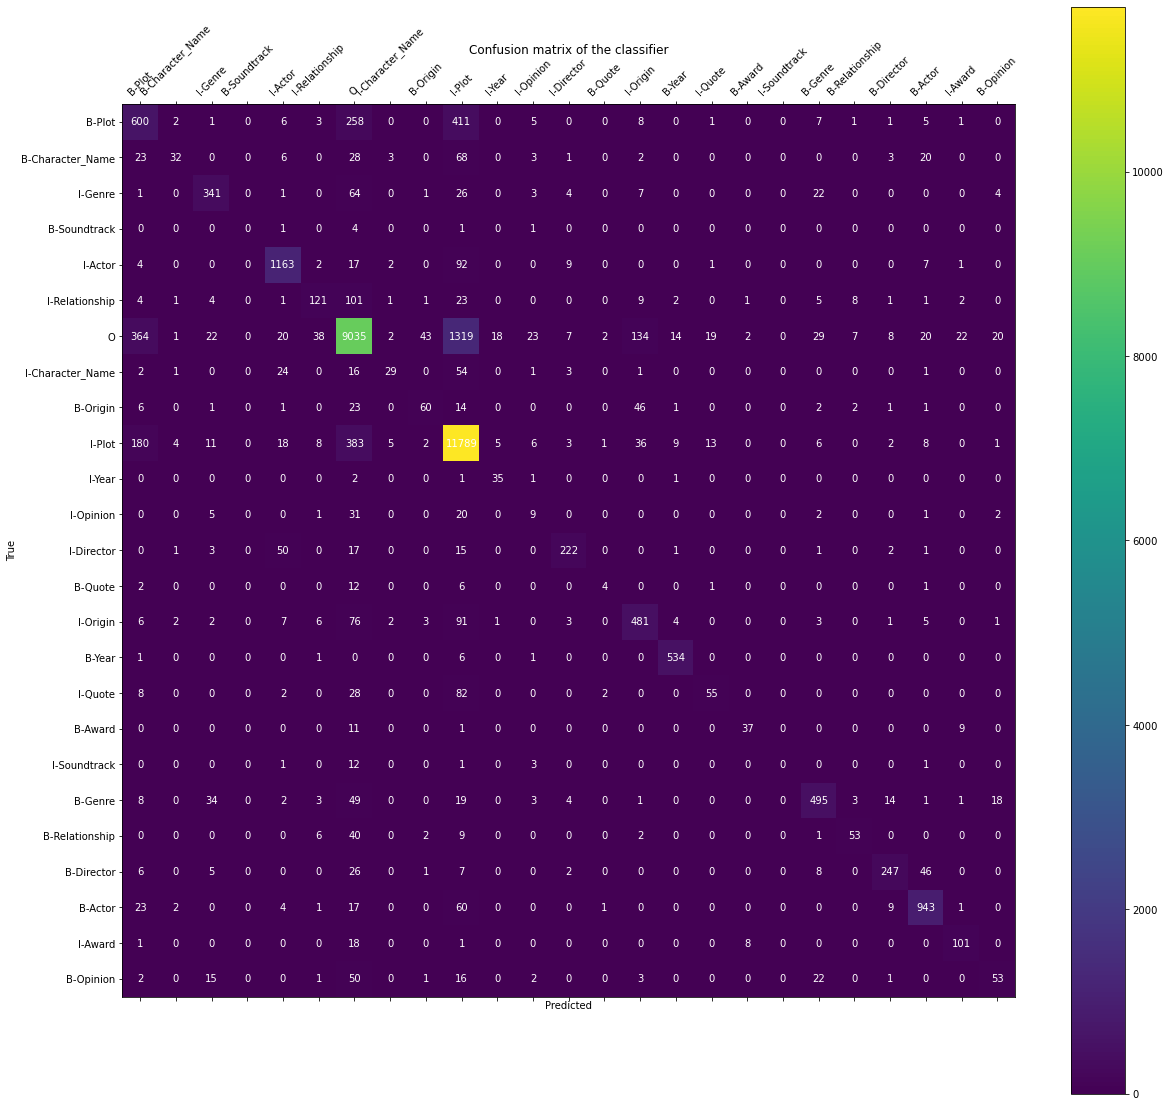

In [29]:
confusion_matrix_heatmap(y_test, preds)

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing.

Note: do not use the test data as it is above for testing/viewing results, for now, only the 20% development split just described. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


# 2. Error analysis 1: False positives (10 marks)

Performing error analyses is a key part of improving your NLP applications. 

For the 5 classes/labels which have the lowest precision score, according to the results table from your 20% development data, print out all the instances (both the words and the corresponding predicted and ground-truth labels) where there is a false positive for that class in the sequence (i.e. a false positive is where the label is predicted for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). Format the printed sequences to make it as clear as possible where the error is in the sequence for a given label. 

HINT: This may be achieved most easily by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. While this is thinking ahead in preparation for Question 5, and not part of the marks here, have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


# 3. Error analysis 2: False negatives (10 marks)

For the 5 classes/labels which have the lowest recall, according to the results table from your 20% development data, print out all the instances (both the words and corresponding predicted and ground-truth labels for the instance), where there is a false negative for that label (i.e. a false negative is when the the label is the ground-truth label for a given word, but that label is not predicted for that word by the tagger). Format the printed sequences to make it as clear as possible where the error is in the sequence for a given label. 

HINT: As per Q2, his may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. While this is thinking ahead in preparation for Question 5, and not part of the marks here, have a look at these errors closely, and think about which features could be added to reduce the number of these errors.

# 4. Using POS tags as features (15 marks)
Use the part-of-speech (POS) tagger (also a CRF tagger object) as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above.

Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`.

Once you're happy you've integrated POS tagging, re-run the training and testing code on your 80%/20% training/dev split you made in Question 1 and record the results from the classification report as text in this file. Compare the accuracy metrics against the original testing you did in Questions 1-3 when not using POS tags- try to see any improvements across the classes (there may not be substantial improvement overall, but some classes will have improved).

In [125]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
tagged = posttagger.tag(words)
print(tagged)

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


In [127]:
for i, t in enumerate(tagged):
    print (i)

0
1
2
3
4


In [21]:
res = [tag[0]+'@'+tag[1] for tag in tagged]
res

['john@NNP', 'likes@VBZ', 'mary@JJ', 'and@CC', 'bill@NN']

# 5. Feature experimentation for optimal macro average (20 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes, rather than just raw accuracy or weighted f-score) on your 20% development data. 

Iteratively try different functions, briefly describe the method and record the results in the classification report format. In terms of feature experimentation, you could try using more suffixes/prefixes of the current word than those currently extracted and you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

For submission, leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. reading in and preprocessing the data from the test file `trivia10k13test.bio.txt`) as your final piece of code. You should not run the model on the test data during development, but only test it right at the end before submission.